This notebook charts the C-Index for surival analysis and makes several visualizations.

In [1]:
import getpass
import os
import sys
import time
from itertools import combinations

import pandas as pd # 0.24.2
import matplotlib as mpl # 3.1.1
import matplotlib.pyplot as plt
import seaborn as sns # 0.9.0
from scipy.stats import wilcoxon

# statsmodels 0.10.1
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

danieldomingo


In [5]:
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [6]:
print(time.asctime())

Wed Oct  9 12:38:58 2019


In [7]:
df = pd.read_csv('../../input/survival_analysis_results.tsv', sep='\t')
df.rename(columns={'C-Index':'CIndex'}, inplace=True) # Rename column to avoid the "-"
df = df.sort_values(['Database', 'Dataset'])
df.Database = df.Database.map(str)
df.Dataset = df.Dataset.map(str.upper)
df.head()

,Database,Dataset,CIndex,L1-Ratio
160,KEGG,BRCA,0.536812,0.19
161,KEGG,BRCA,0.531958,0.19
162,KEGG,BRCA,0.606050,0.29
163,KEGG,BRCA,0.618121,0.23
164,KEGG,BRCA,0.552300,0.17


In [8]:
formula = 'CIndex ~ C(Database)*C(Dataset)'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                          sum_sq     df         F    PR(>F)
C(Database)             0.025103    5.0  1.252455  0.284936
C(Dataset)              0.098123    4.0  6.119645  0.000100
C(Database):C(Dataset)  0.115348   20.0  1.438783  0.103817
Residual                1.082306  270.0       NaN       NaN


Pairwise comparion of C-Index distributions across resources using Wilcoxon test

In [9]:
rows = []

for dataset, df_dataset in df.groupby('Dataset'):
    databases = df_dataset['Database'].unique()
    
    for db1, db2 in combinations(databases, r=2):
        
        # Get C-Indexes for the comparison of database
        cindex1 = df_dataset[df_dataset['Database'] == db1]["CIndex"].to_list()
        cindex2 = df_dataset[df_dataset['Database'] == db2]["CIndex"].to_list()
        
        # Conduct Wilcoxon Test
        _, p_value = wilcoxon(cindex1, cindex2)
        
        rows.append((
            dataset,
            f"{db1}-{db2}",
            p_value,
        ))
        
# Stick results into DF
results = pd.DataFrame(
    rows,
    columns=[
        'dataset',
        'comparison',
        'wilcoxon_p',
    ],
)

reject, q_values, _, _ = multipletests(results["wilcoxon_p"], method="bonferroni")
results["reject"] = reject
results["q_values"] = q_values

In [10]:
results.query('reject == True')

,dataset,comparison,wilcoxon_p,reject,q_values


Plot C-Indexes for each Database/Dataset

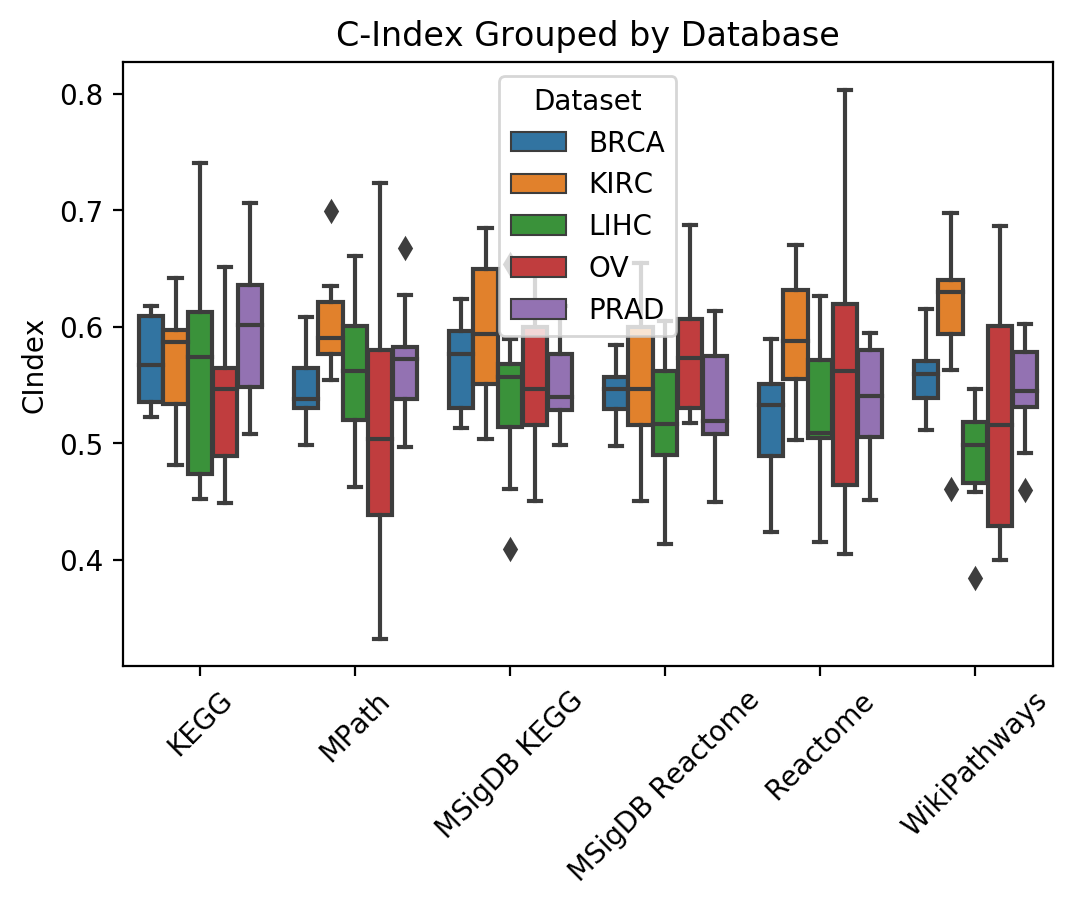

In [11]:
ax = sns.boxplot(
    y='CIndex',
    x='Database',
    hue='Dataset',
    data=df,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('')
plt.title('C-Index Grouped by Database')
plt.show()

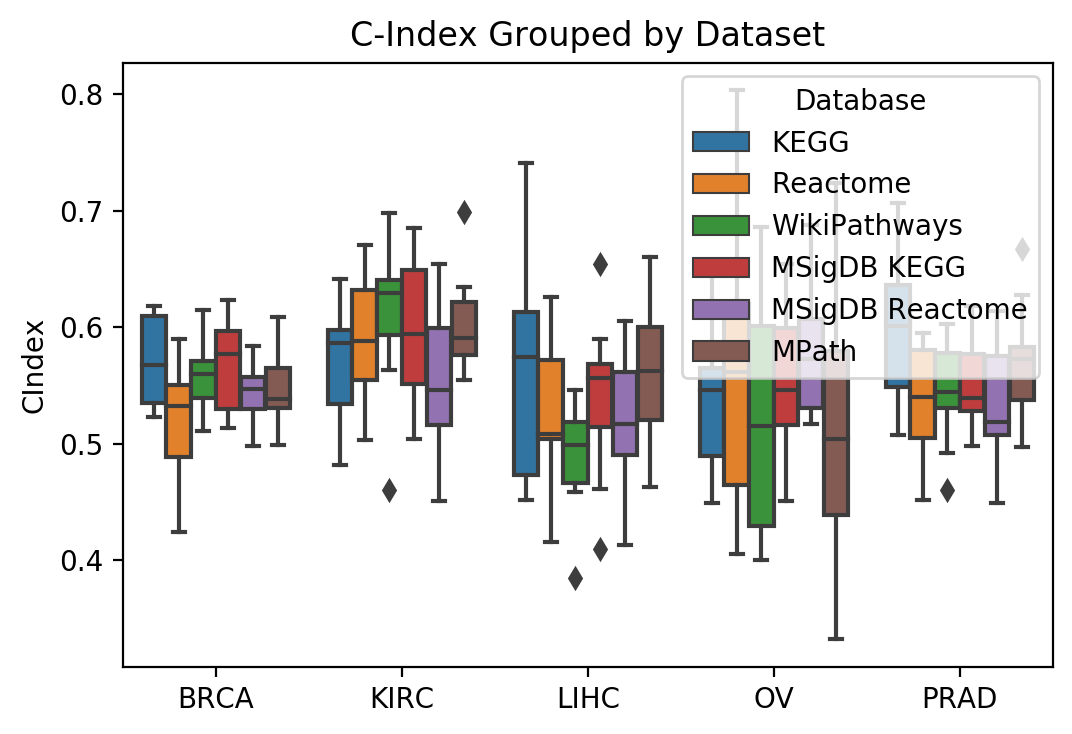

In [12]:
ax = sns.boxplot(
    y='CIndex',
    x='Dataset',
    hue='Database',
    data=df,
    hue_order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'MPath'],
)
plt.xlabel('')
plt.title('C-Index Grouped by Dataset')
plt.show()

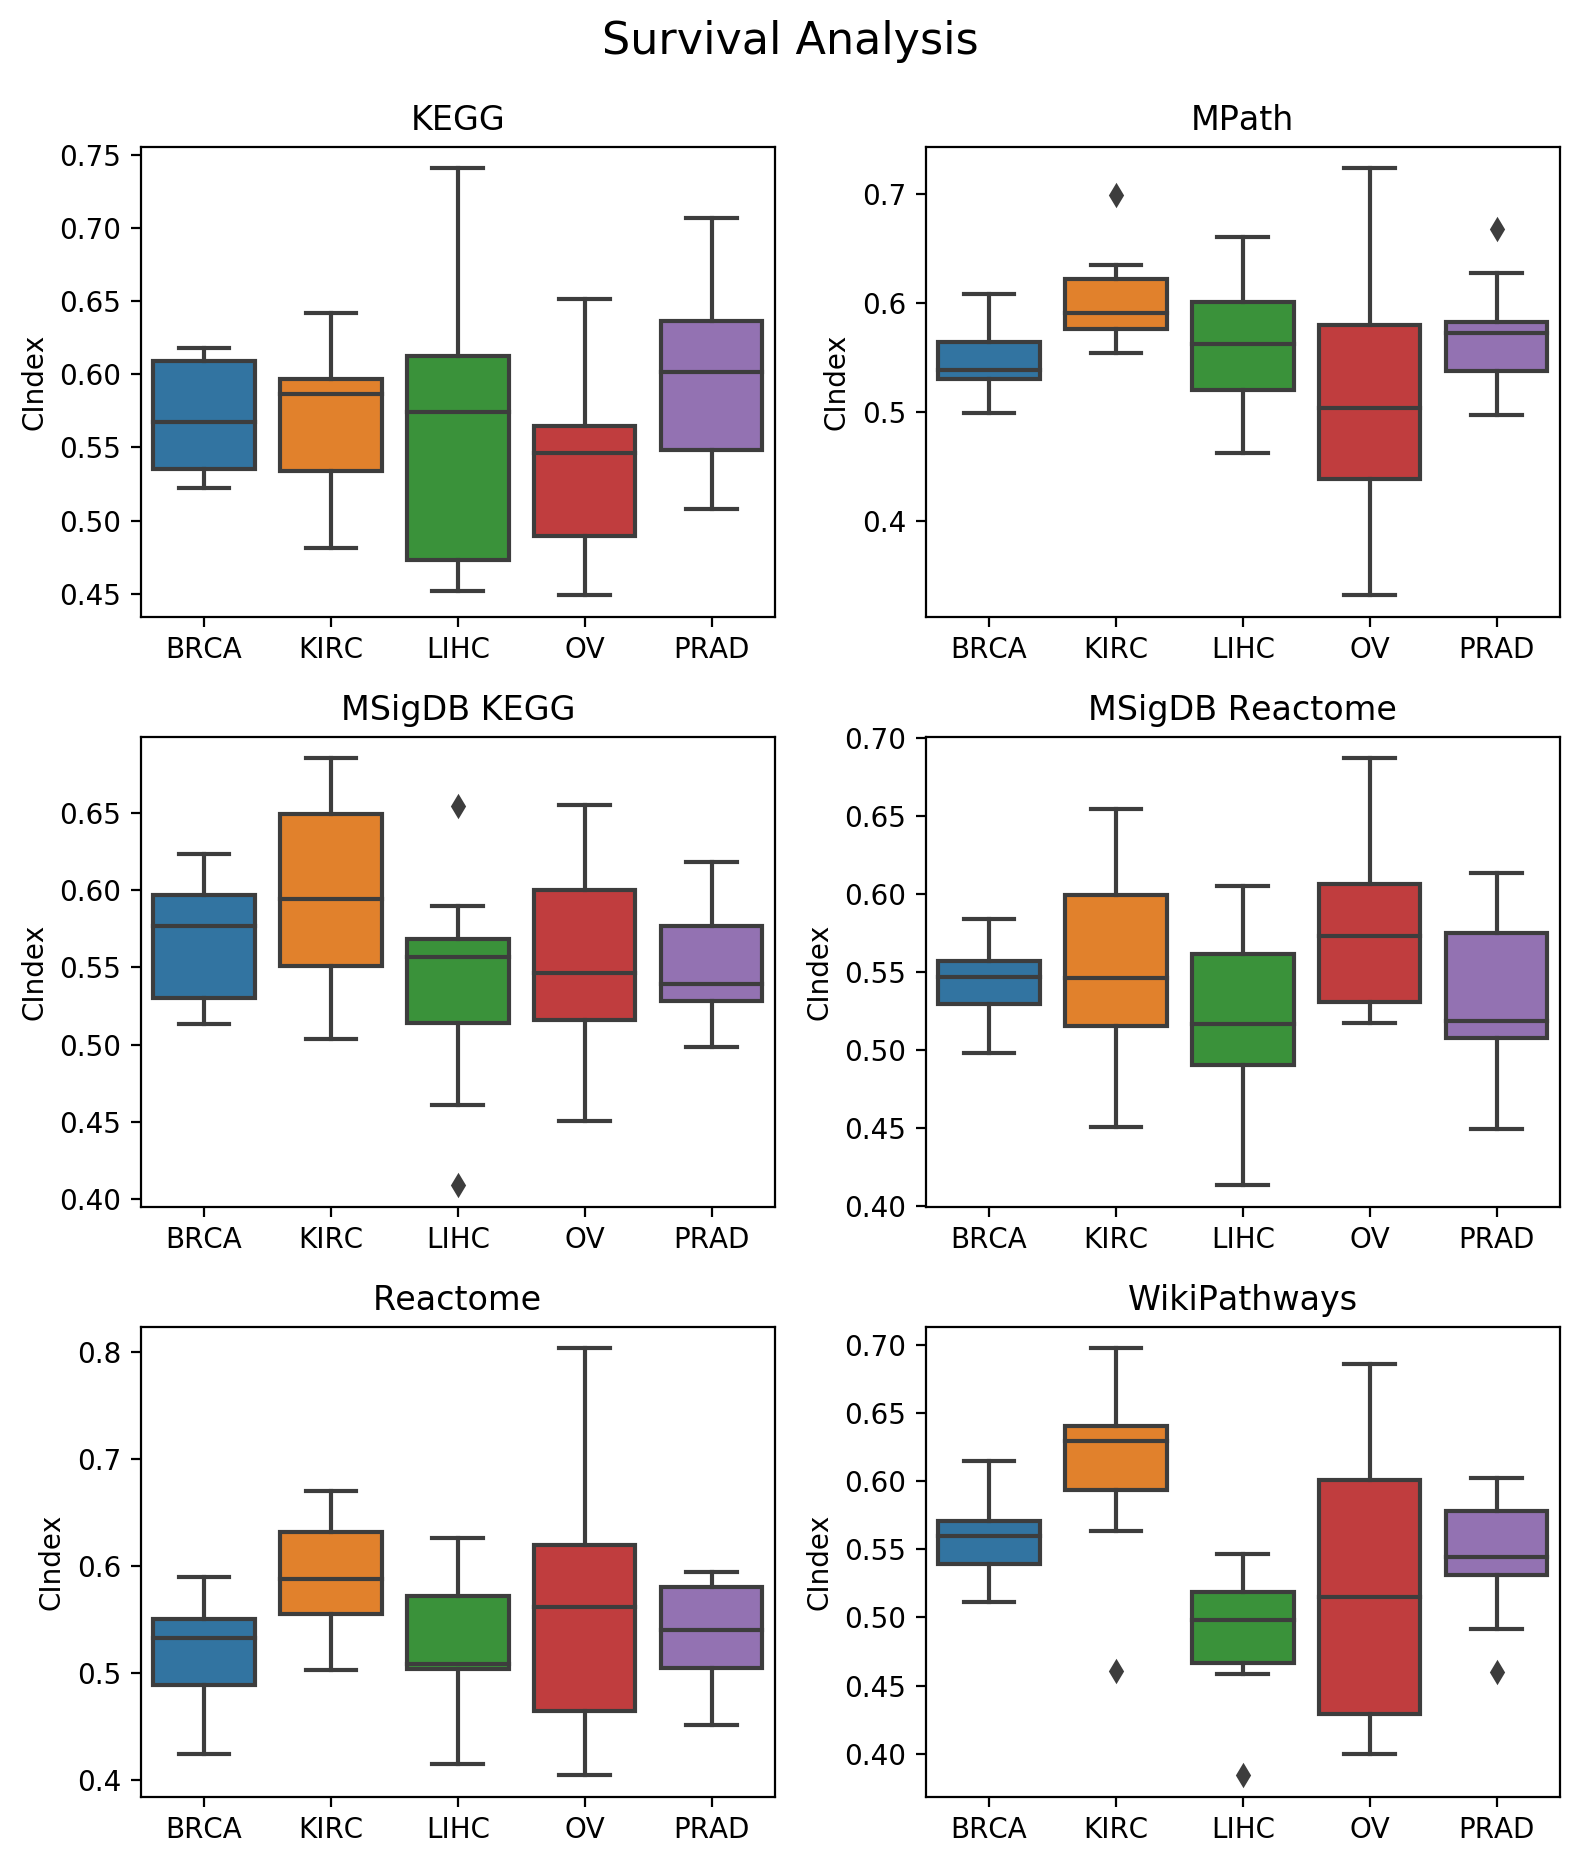

In [13]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 9))

plt.suptitle('Survival Analysis', fontsize=16, y=1.03)

y_min = df['CIndex'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='CIndex',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

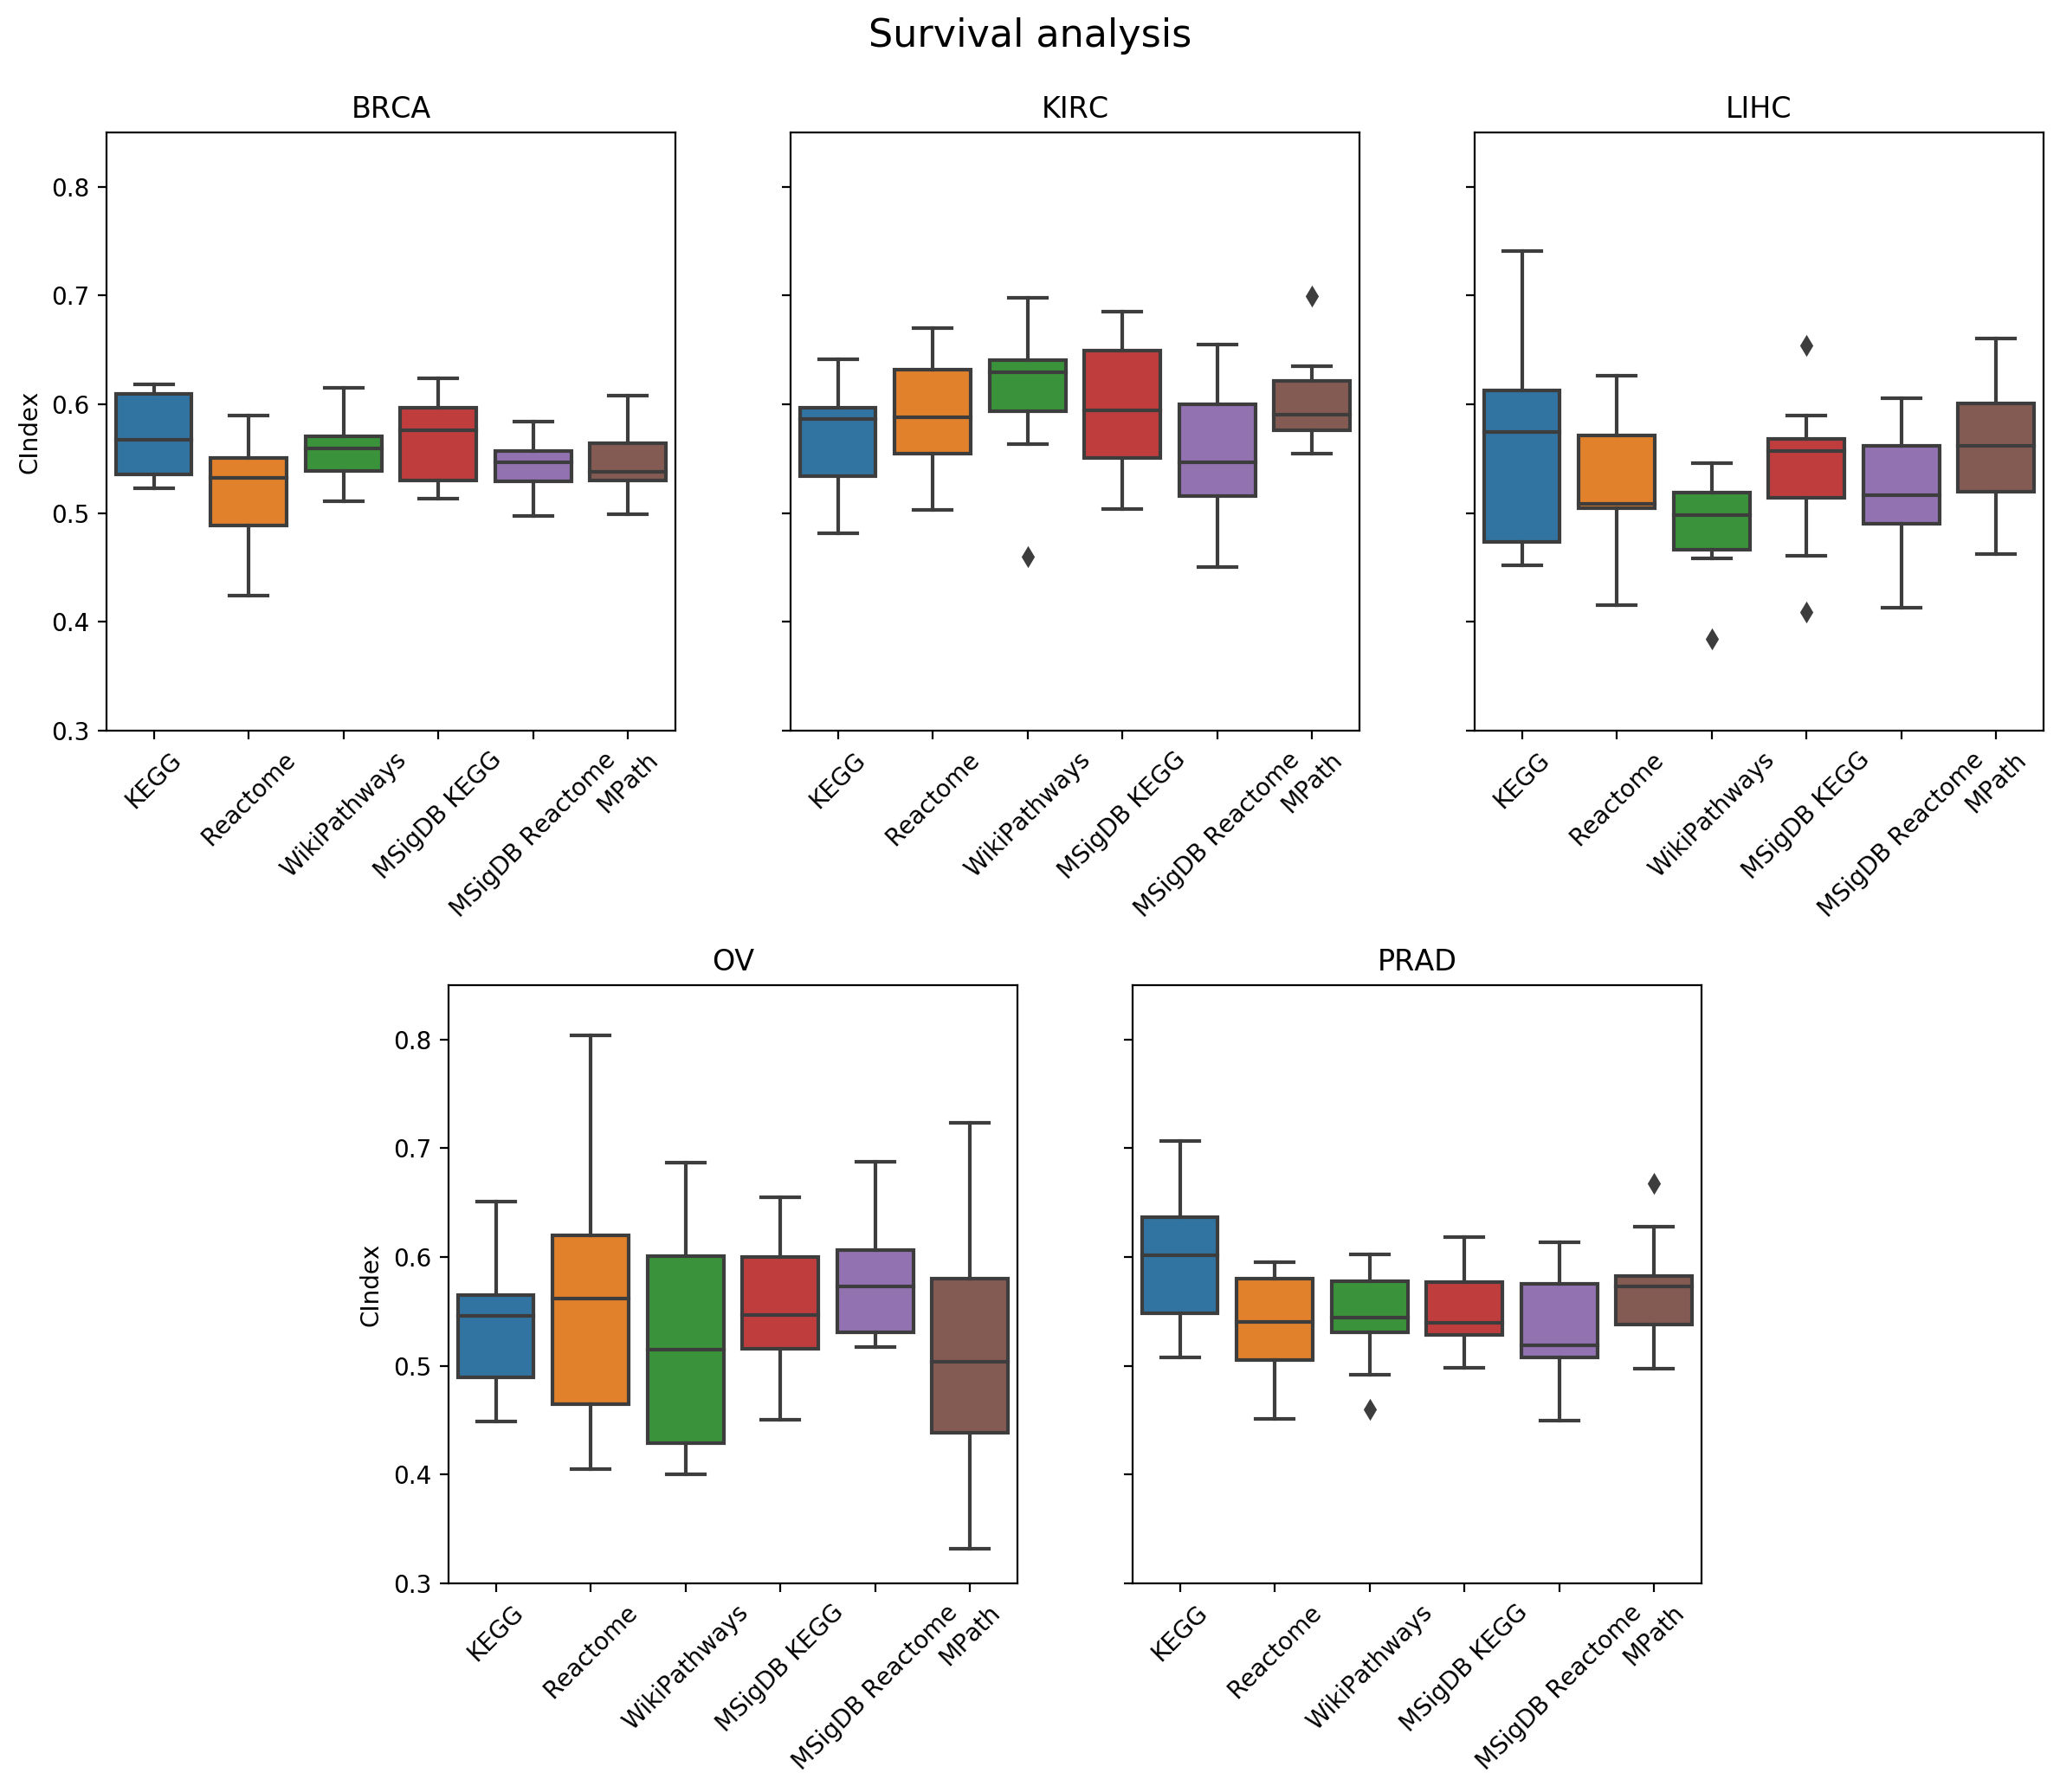

In [14]:
fig = plt.figure(figsize=(12, 10)) 

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

suptitle = plt.suptitle('Survival analysis', fontsize=16, y=1.03)

for plot_num, (dataset, ax) in enumerate(zip(df['Dataset'].unique(), [ax1, ax2, ax3, ax4, ax5])):
    
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='CIndex',
        x='Database',
        data=df[df['Dataset'] == dataset],
        order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'MPath'],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Set y limit
    ax.set_ylim([0.3, 0.85])
    
    # Hide x label in all plots and leave y axis label for the leftmost plots
    ax.set_xlabel('')
    if plot_num in {1,2,4}:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False) 
        
plt.tight_layout()
plt.savefig(
    os.path.join(os.path.expanduser('~'), 'Desktop', 'survival.png'),
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()